<a href="https://colab.research.google.com/github/DrAlexSanz/nlpv2-course/blob/master/Markov_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Theory

Model a sequence as a state machine, with probabilities of transitions

I will represent my language with a transition matrix and a state-probability matrix.

* $A_{11}$ is the probability of going from state 1 to 1 and so on $\frac{count(i to j)}{count(i)}$ = $\frac{counts("the cat")}{count("the")}$


* $\pi_1$ is the state distribution = $\frac{counts(s = 1)}{N_{words}}$ = $\frac{counts("cat")}{N_{words}}$

Since we are always multiplying I can get 0 if a transition is not in the train set. I can add 1 to all the transitions to avoid that the whole thing becomes 0.

Then 

$A_{i→j} = \frac{count(i→j) + 1}{count(i) + M}$

Where M is the number of words, then each row of $A$ adds to 1. Instead of 1 I can add $ϵ$ to avoid issues with 1, and then in the denominator I add $ϵ\cdot M$.



Since we are always multiplying and the probabilities are small, they will tend to 0. That's bad because I don't have enough resolution, but I can take logarithms and convert the multiplications to sums.

## Text classifier

Given a text, tell me if it was written by Robert Frost or by Poe. I will train a Markov model for each class.

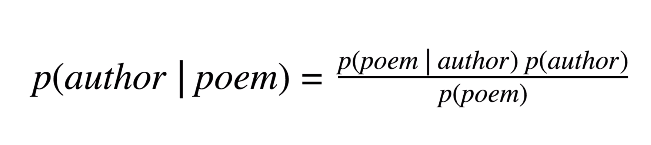

Now implement the classifier

In [50]:
# Download data

!wget -nc https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/hmm_class/edgar_allan_poe.txt

!wget -nc https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/hmm_class/robert_frost.txt

'wget' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.


In [51]:
import numpy as np
import string
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [52]:
input_files = ["edgar_allan_poe.txt", "robert_frost.txt"]

### Print the head of the files to see what there is inside.

Note there are capital letters, punctuation, empty lines...

In [53]:
!head edgar_allan_poe.txt

'head' is not recognized as an internal or external command,
operable program or batch file.


In [54]:
!head robert_frost.txt

'head' is not recognized as an internal or external command,
operable program or batch file.


Create two lists, one element will be one line, and I can deal with the cleaning easily.

In [55]:
input_texts = []
labels = []

for label, f in enumerate(input_files):
    print(f"Label {label} corresponds to author {f}")

    for line in open(f):
        line = line.rstrip().lower()
        if line:
            line = line.translate(str.maketrans("", "", string.punctuation))

            input_texts.append(line)
            labels.append(label)

Label 0 corresponds to author edgar_allan_poe.txt
Label 1 corresponds to author robert_frost.txt


### Train/test split now, tokenize later. I should keep an UNK token.

In [56]:
x_train, x_test, y_train, y_test = train_test_split(input_texts, labels)

Check

In [57]:
print(len(x_train), len(y_train), len(x_test), len(y_test))
print(x_train[:5])
print(y_train[:5])

1618 1618 540 540
['drawn by their hearts passion and that tone', 'italian tones made only to be murmured', 'with a strange sound as of a harpstring broken', 'as if by eye pairs out of forty firkins', 'a passionate light such for his spirit was fit']
[0, 0, 0, 1, 0]


Start tokenization

In [58]:
idx = 1

word2idx = {"UNK": 0}

# And now populate the word2idx dictionary

for line in x_train:
    tokens = line.split()
    for word in tokens:
        if word not in word2idx:
            word2idx[word] = idx
            idx += 1

len(word2idx) # This will determine the size of A (State matrix). It will be len x len
#word2idx # This is a mapping, not a count

2550

In [59]:
# Now I tokenize the train/test x lists

x_train_tokens = []
x_test_tokens = []

for elem in x_train: # I will never have UNKs here because I used this to create the vocab.
    tokens = elem.split()
    line_as_tokens = [word2idx[token] for token in tokens]
    x_train_tokens.append(line_as_tokens)

for elem in x_test: # Need to be careful with UNKs, there can be some here
    tokens = elem.split() # This is the same
    line_as_tokens = [word2idx.get(token, 0) for token in tokens] # Null handling again!
    x_test_tokens.append(line_as_tokens)

# Check
print(x_train[13:26])
print(x_train_tokens[13:26])


['to come to his house when hes gone to yours', 'here he is now this box put it away', 'to shine on us with her bright eyes ', 'nowhere but here', 'a single leaf was on a bough', 'from their deeptoned throats', 'was only adding frost to snow', 'he cant find anyone to take her place', 'not to sink under being man and wife', 'he couldnt climb that slippery slope', 'their office is to illumine and enkindle', 'a hideous throng rush out forever', 'beloved amid the earnest woes']
[[13, 74, 13, 34, 75, 76, 77, 78, 13, 79], [80, 45, 81, 82, 83, 84, 85, 44, 86], [13, 87, 88, 89, 16, 90, 91, 92], [93, 63, 80], [17, 94, 95, 36, 88, 17, 96], [97, 3, 98, 99], [36, 12, 100, 101, 13, 102], [45, 103, 104, 105, 13, 106, 90, 107], [64, 13, 108, 109, 110, 111, 6, 112], [45, 113, 114, 7, 115, 116], [3, 117, 81, 13, 118, 6, 119], [17, 120, 121, 122, 27, 123], [124, 125, 40, 126, 127]]


In [60]:
# Initialize matrices A and pi for each class

V = len(word2idx)

A_0 = np.ones((V, V)) # Can initialize with np.zeros, but I'm using 1-smoothing.
pi_0 = np.ones(V)

A_1 = np.ones((V, V))
pi_1 = np.ones(V)

In [61]:
# Word counts

def compute_counts(text_as_int, A, pi):
    """
    Compute counts for A and pi
    """

    for tokens in text_as_int:
        last_idx = None
        for idx in tokens:
            if last_idx is None:
                # If it's the first word in a sentence
                pi[idx] += 1 # First word, initial state distribution
            else:
                A[last_idx, idx] +=1 # Not first word, we are representing a transition

            last_idx = idx

    return

In [62]:
compute_counts([t for t, y in zip(x_train_tokens, y_train) if y_train == 0], A_0, pi_0) # Populate for the first class
compute_counts([t for t, y in zip(x_train_tokens, y_train) if y_train == 1], A_1, pi_1)

In [63]:
# Normalize the counts so we have a probability matrix instead of counts

A_0 = A_0/A_0.sum(axis = 1, keepdims = True) # Divide by row sums
pi_0 = pi_0/pi_0.sum()

A_1 = A_1/A_1.sum(axis = 1, keepdims = True)
pi_1 = pi_1/pi_1.sum()

# And log p

log_A_0 = np.log(A_0)
log_pi_0 = np.log(pi_0)

log_A_1 = np.log(A_1)
log_pi_1 = np.log(pi_1)

In [64]:
# Compute priors

count_0 = sum(y == 0 for y in y_train)
count_1 = sum(y == 1 for y in y_train)
# I have twice the amount of 1s than 0s

total = len(y_train)
p_0 = count_0 / total
p_1 = count_1 / total

log_p_0 = np.log(p_0)
log_p_1 = np.log(p_1)


In [65]:
# Now build the classifier

class Classifier:
    def __init__(self, log_As, log_pis, log_priors):
        self.log_As = log_As
        self.log_pis = log_pis
        self.log_priors = log_priors
        self.K = len(log_priors)

    def _compute_log_likelihood(self, input_, class_):
        log_A = self.log_As[class_]
        log_pi = self.log_pis[class_]

        last_idx = None
        log_prob = 0
        for idx in input_:
            if last_idx is None:
                log_prob += log_pi[idx]
            else:
                log_prob += log_A[last_idx, idx]
        
        return log_prob

    def predict(self, inputs):
        predictions = np.zeros(len(inputs))
        for i, input_ in enumerate(inputs):
            posteriors = [self._compute_log_likelihood(input_, c) + self.log_priors[c] for c in range(self.K)]
            pred = np.argmax(posteriors)
            predictions[i] = pred

        return predictions
                

In [66]:
clf = Classifier([log_A_0, log_A_1], [log_pi_0, log_pi_1], [log_p_0, log_p_1]) # Keep order!

In [67]:
p_train = clf.predict(x_train_tokens)
print(f"Train accuracy: {np.mean(p_train == y_train)}") # It's not really learning, it's doing just a random prediction

p_test = clf.predict(x_test_tokens)
print(f"Test accuracy: {np.mean(p_test == y_test)}")

Train accuracy: 0.669344870210136
Test accuracy: 0.6537037037037037
